In [1]:
import os
import glob
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
path = os.getcwd()
all_files = glob.glob(os.path.join(path, '*.csv'))
all_files.sort()

## Some data preparation as combining all the csv files for a even a quarter and reading them in a DataFrame would overload the memory

So we parse every csv file separately and 

In [3]:
index = ['Hitachi HDS5C3030ALA630', 'Hitachi HDS5C4040ALE630',
       'ST4000DM000', 'HGST HMS5C4040BLE640', 'WDC WD30EFRX',
       'ST8000DM002', 'WDC WD5000LPVX', 'HGST HMS5C4040ALE640',
       'Hitachi HDS723030ALA640', 'TOSHIBA MD04ABA400V', 'ST6000DX000',
       'TOSHIBA DT01ACA300', 'WDC WD60EFRX', 'ST4000DX000',
       'HGST HUH728080ALE600', 'ST500LM012 HN', 'ST8000NM0055',
       'TOSHIBA MD04ABA500V', 'WDC WD1600AAJS', 'ST9320325AS',
       'WDC WD40EFRX', 'HGST HDS5C4040ALE630', 'HGST HDS724040ALE640',
       'Hitachi HDS5C3030BLE630', 'ST9250315AS',
       'Hitachi HDS724040ALE640', 'TOSHIBA MQ01ABF050', 'ST31500541AS',
       'ST3160318AS', 'WDC WD5000LPCX', 'WDC WD20EFRX', 'ST3160316AS',
       'WDC WD3200BEKX', 'Hitachi HDS723030BLE640', 'WDC WD2500BPVT',
       'WDC WD5000BPKT', 'ST250LM004 HN', 'ST320LT007',
       'Hitachi HDT725025VLA380', 'ST4000DX002', 'WDC WD3200AAJS',
       'ST6000DM001', 'WDC WD2500AAJS', 'WDC WD3200LPVX',
       'WDC WD2500BEVT', 'WDC WD5003ABYX', 'WDC WD5002ABYS',
       'Hitachi HDS722020ALA330', 'ST1000LM024 HN', 'ST33000651AS',
       'WDC WD1600BPVT', 'ST3500320AS', 'WDC WD10EADS', 'WDC WD10EACS',
       'WDC WD10EADX', 'WDC WD1000FYPS']
df = pd.DataFrame(index=index)
failures = pd.DataFrame(index=index)
for file in all_files:
    filename = os.path.splitext(os.path.basename(file))[0]
    temp = pd.read_csv(file)
    df[filename] = temp.groupby('model').size()
    failures[filename] = temp.groupby('model')['failure'].agg(sum)
df['drives_days'] = df.sum(axis=1)
failures['total'] = failures.sum(axis=1)

In [6]:
failure_rates = failures['total'] / df['drives_days'] * 365 * 100

# Plots of annualized failure rates by model

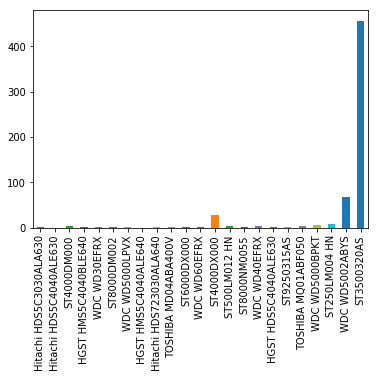

In [20]:
failure_rates[failure_rates > 0].plot(kind="bar")

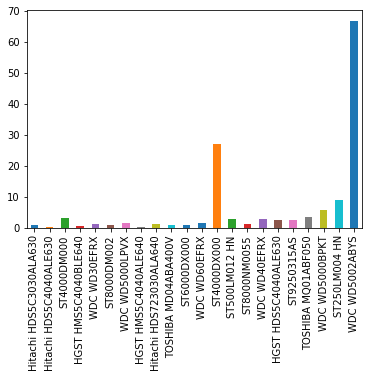

In [19]:
failure_rates[(0 < failure_rates)  & (failure_rates < 400)].plot(kind="bar")

Those plots give us a first idea of what happens with certain hard drives. But we have to go a little further as the expected lifetime of a hard drive is certainly more than a year.

In [30]:
nb_hard_drives = df['2017-01-01']

# Proportions of models in the hard drives park

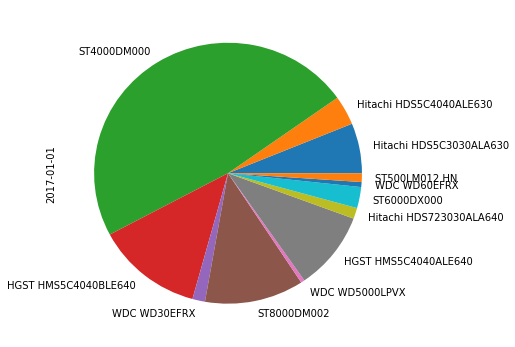

In [40]:
nb_hard_drives[nb_hard_drives > 250].plot.pie(figsize=(6,6))